<a href="https://colab.research.google.com/github/aisyahbil/alzheimer_classification/blob/main/VIT_train_val.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U tensorflow-addons
!pip install datasets
!pip install -q transformers datasets
!pip install accelerate -U
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.0 MB/s eta 0:00:00


In [ ]:
import optuna
from transformers import TrainingArguments, Trainer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import StratifiedKFold
import albumentations as A
from tqdm import tqdm
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from transformers import ViTFeatureExtractor, ViTForImageClassification

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from sklearn.model_selection import train_test_split
from transformers import ViTImageProcessor
from torchvision.transforms import (CenterCrop, Compose, Normalize, RandomRotation, RandomResizedCrop, RandomHorizontalFlip, RandomAdjustSharpness, Resize, ToTensor)
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import torch
from datasets import Dataset, DatasetDict

#Train

In [ ]:
# Load the dataset
dataset = load_dataset("Falah/Alzheimer_MRI")
full_data = load_dataset('Falah/Alzheimer_MRI', split='train')

# Split the dataset into training and validation sets
train_data, val_data = train_test_split(full_data, test_size=0.2, random_state=42)

label = list(set(train_data['label']))
id2label = {id: label for id, label in enumerate(label)}
label2id = {label: id for id, label in id2label.items()}
print(id2label, label2id)

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose([
    Resize((size, size)),
    RandomRotation(15),
    RandomAdjustSharpness(2),
    ToTensor(),
    normalize,
])

_val_transforms = Compose([
    Resize((size, size)),
    ToTensor(),
    normalize,
])

train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

train_dataset.set_transform(train_transforms)
val_dataset.set_transform(val_transforms)

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([label2id[example["label"]] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=4)

print(train_dataloader)
print(val_dataloader)

batch = next(iter(train_dataloader))
for k,v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

batch = next(iter(val_dataloader))
for k,v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

metric_name = "accuracy"

# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)

args = TrainingArguments(
    "Alzheimer_MRI
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

import torch
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
    optimizers=(optimizer, None)  # Pass the optimizer
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


{0: 0, 1: 1, 2: 2, 3: 3} {0: 0, 1: 1, 2: 2, 3: 3}
Size:  224
pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])
pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.847015,0.585938
2,No log,0.745394,0.666016
3,No log,0.676526,0.716797
4,0.779500,0.610468,0.760742
5,0.779500,0.598168,0.779297
6,0.779500,0.506383,0.812500
7,0.779500,0.413709,0.859375


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.847015,0.585938
2,No log,0.745394,0.666016
3,No log,0.676526,0.716797
4,0.779500,0.610468,0.760742
5,0.779500,0.598168,0.779297
6,0.779500,0.506383,0.812500
7,0.779500,0.413709,0.859375
8,0.404100,0.390133,0.868164
9,0.404100,0.384808,0.865234
10,0.404100,0.369712,0.877930


TrainOutput(global_step=2560, training_loss=0.3065655153244734, metrics={'train_runtime': 3426.5187, 'train_samples_per_second': 23.908, 'train_steps_per_second': 0.747, 'total_flos': 6.348257582037074e+18, 'train_loss': 0.3065655153244734, 'epoch': 20.0})

#Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Save Model

In [ ]:
trainer.save_model('/content/drive/MyDrive/MODEL ALZHEIMER/fine-tuned-model(20 epoch)')

#Testing

In [ ]:
test_data = load_dataset('Falah/Alzheimer_MRI', split='test')

label = list(set(test_data['label']))
id2label = {id: label for id, label in enumerate(label)}
label2id = {label: id for id, label in id2label.items()}
print(id2label, label2id)

processor = ViTImageProcessor.from_pretrained("/content/drive/MyDrive/MODEL ALZHEIMER/fine-tuned-model(20 epoch)")

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)
_test_transforms = Compose([
    Resize((size, size)),
    RandomRotation(15),
    RandomAdjustSharpness(2),
    ToTensor(),
    normalize,
])

def test_transforms(examples):
    examples['pixel_values'] = [_test_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

test_data.set_transform(test_transforms)

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([label2id[example["label"]] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

test_dataloader = DataLoader(test_data, collate_fn=collate_fn, batch_size=4)

print(test_dataloader)

batch = next(iter(test_dataloader))
for k,v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

model = ViTForImageClassification.from_pretrained("/content/drive/MyDrive/MODEL ALZHEIMER/fine-tuned-model(20 epoch)")

# Define the testing arguments
test_args = TrainingArguments(
    "Alzheimer-test",
    per_device_eval_batch_size=4,
    logging_dir='logs',
    remove_unused_columns=False,
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    f1 = f1_score(labels, predictions, average='weighted')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# Create the Trainer for testing
test_trainer = Trainer(
    model,
    test_args,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

# Run the evaluation on the testing
test_trainer.evaluate()

{0: 0, 1: 1, 2: 2, 3: 3} {0: 0, 1: 1, 2: 2, 3: 3}
Size:  224
pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


{'eval_loss': 0.22325673699378967,
 'eval_accuracy': 0.93828125,
 'eval_precision': 0.939498295062311,
 'eval_recall': 0.93828125,
 'eval_f1': 0.9375747362908722,
 'eval_runtime': 18.0787,
 'eval_samples_per_second': 70.801,
 'eval_steps_per_second': 17.7}

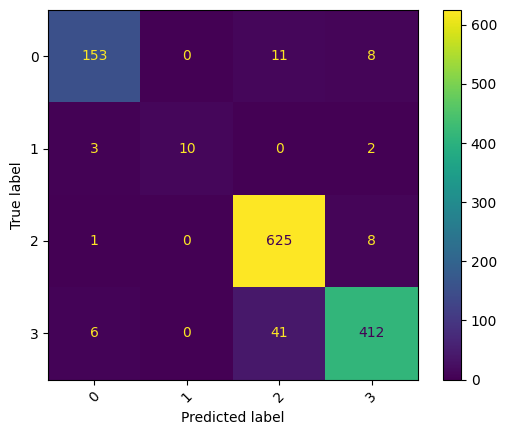

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions from the test trainer
test_predictions = test_trainer.predict(test_data)
predicted_labels = np.argmax(test_predictions.predictions, axis=1)

# Iterate over the test data to get true labels
true_labels = []
for batch in test_dataloader:
    true_labels.extend(batch["labels"].numpy())

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
labels = ["0", "1", "2", "3"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

# Show the plot
plt.show()
